In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import torch
from torch import nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import (
    evaluate_loop, 
    read_and_window_session,
    read_session,
    train_loop,
    optimization_loop,
    predict_and_plot_pretty_session
)
from lib.utils import (
    plot_and_save_cm,
    summary
)
from lib.models import  MLP, MLP2hl
from tqdm import tqdm
import plotly.express as px
from tabulate import tabulate

In [3]:
raw_dir = Path("/home/mmazeem/datasets/nursingv1")
label_dir = Path("/home/mmazeem/datasets/eating_labels")
WINSIZE = 505
DEVICE = 'cuda'

In [4]:
train_sessions = [25, 67]
test_sessions = [58, 62]

Xs = []
ys = []

for session_idx in train_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xtr = torch.cat(Xs)
ytr = torch.cat(ys)

Xs = []
ys = []

for session_idx in test_sessions:
    X,y = read_and_window_session(session_idx, WINSIZE, raw_dir, label_dir)

    Xs.append(X)
    ys.append(y)

Xte = torch.cat(Xs)
yte = torch.cat(ys)

In [6]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.p_size = 101
        self.n_channels = 3

        self.lstm = nn.LSTM(
            input_size=self.p_size*self.n_channels,
            hidden_size=64,
            bias=False,
            batch_first=True
        )
        self.mlp = nn.Sequential(
            nn.Linear(in_features=64, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )

    def partition_window(self, x, p_size, n_channels):
        x = x.view(-1, n_channels, WINSIZE)
        x = x.transpose(1,2).view(-1, WINSIZE//p_size, p_size, n_channels)
        x = x.transpose(2,3).flatten(start_dim=2)
        return x

    def forward(self, x):
        x = self.partition_window(x, p_size=self.p_size, n_channels=self.n_channels)
        o, (h,c) = self.lstm(x) # o is shape (batch_size, p_size, 64)
        o = nn.ReLU()(o[:,-1,:])
        logits = self.mlp(o)

        return logits


model = LSTM().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

Epoch 1: Train Loss: 0.11648: 100%|██████████| 2/2 [00:30<00:00, 15.00s/it]


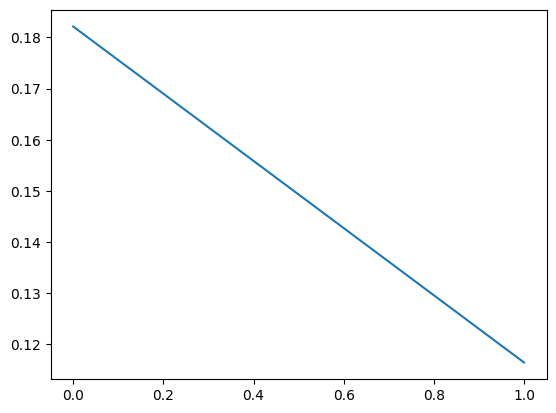

In [7]:
trainloader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)

train_loop(model, trainloader, criterion, optimizer, 2, DEVICE)

/home/mmazeem/.local/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


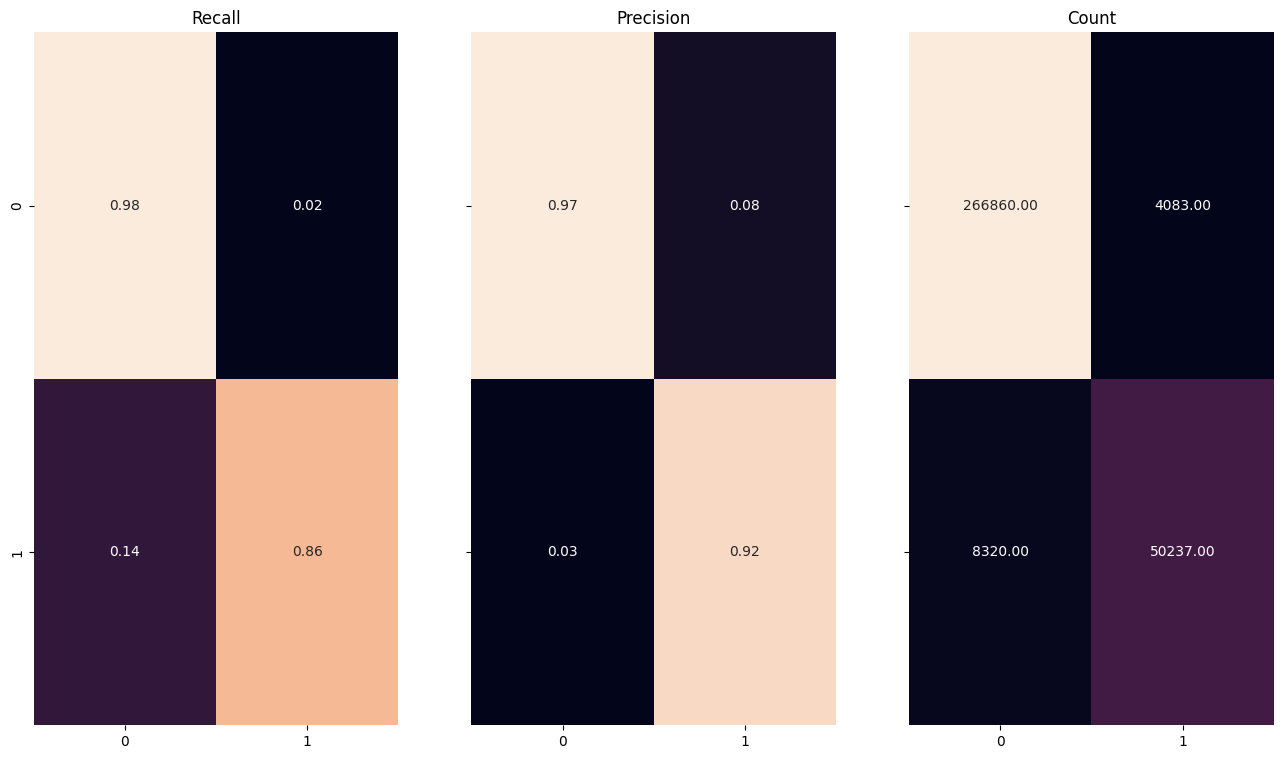

Metric        Value
---------  --------
loss       0.09965
precision  0.924834
recall     0.857916
f1         0.890119


In [29]:
ys,metrics = evaluate_loop(model, criterion, trainloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

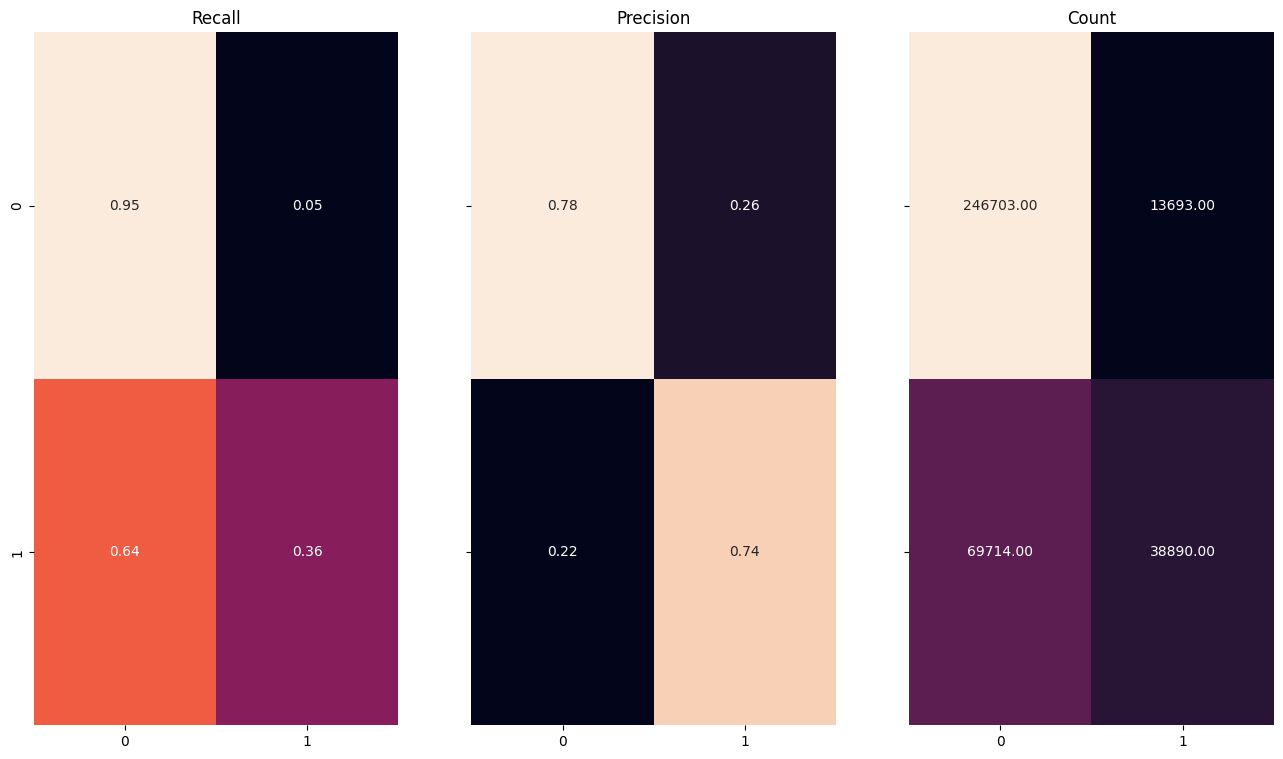

Metric        Value
---------  --------
loss       1.26753
precision  0.739593
recall     0.35809
f1         0.482545


In [82]:
testloader = DataLoader(TensorDataset(Xte,yte), batch_size=64)

ys,metrics = evaluate_loop(model, criterion, testloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

In [107]:
test_session = test_sessions[0]

predict_and_plot_pretty_session(
    session_idx=test_session,
    dim_factor=5,
    datapath=raw_dir,
    labelpath=label_dir,
    winsize=WINSIZE,
    model=model,
    criterion=criterion,
    batch_size=64,
    device=DEVICE
)

Metric        Value
---------  --------
loss       0.846379
precision  0.634748
recall     0.181385
f1         0.282145


Gtk-Message: 12:50:07.555: Failed to load module "xapp-gtk3-module"
Gtk-Message: 12:50:07.556: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
Gtk-Message: 12:50:07.556: Failed to load module "appmenu-gtk-module"

(brave:43847): Gtk-WARNING **: 12:50:07.635: GTK+ module /snap/brave/295/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 12:50:07.635: Failed to load module "canberra-gtk-module"

(brave:43847): Gtk-WARNING **: 12:50:07.636: GTK+ module /snap/brave/295/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 12:50:07.636: Failed to load module "canberra-gtk-module"


Opening in existing browser session.
